In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import nsdiffs, ndiffs
from pmdarima import auto_arima

In [2]:
file_path = r"C:\Users\huawei\OneDrive\桌面\limited.csv"

# 读取数据，time列解析为日期但不设为索引
df = pd.read_csv(file_path, parse_dates=['time'])

# 按时间列从小到大排序
df = df.sort_values('time').reset_index(drop=True)

print(df.head(3))
print(df.tail(3))
print(df.dtypes)
print(f"\n数据形状：{df.shape}")
print(f"时间范围：{df['time'].min()} 到 {df['time'].max()}")

        time  GDP_4cum  city_mean_light  region_mean_light title website  \
0 2008-01-01   1634.65        12.553247           0.953015  (填补)    none   
1 2008-04-01   3346.63        13.280818           0.986813  (填补)    none   
2 2008-07-01   5351.74        13.191190           0.972665  (填补)    none   

   Year  Month      GDP    ln_gdp   ln_city  ln_region  city_prop  \
0  2008      1  1634.65  7.399184  2.529979  -0.048125     0.2381   
1  2008      4  1711.98  7.445406  2.586321  -0.013275     0.2519   
2  2008      7  2005.11  7.603454  2.579549  -0.027716     0.2502   

   region_prop  city_yearly_sum  region_yearly_sum  
0       0.2425        52.722581           3.929959  
1       0.2511        52.722581           3.929959  
2       0.2475        52.722581           3.929959  
         time  GDP_4cum  city_mean_light  region_mean_light  \
61 2023-04-01  16297.60        20.919221           2.673637   
62 2023-07-01  24468.25        23.671801           2.823828   
63 2023-10-01  34

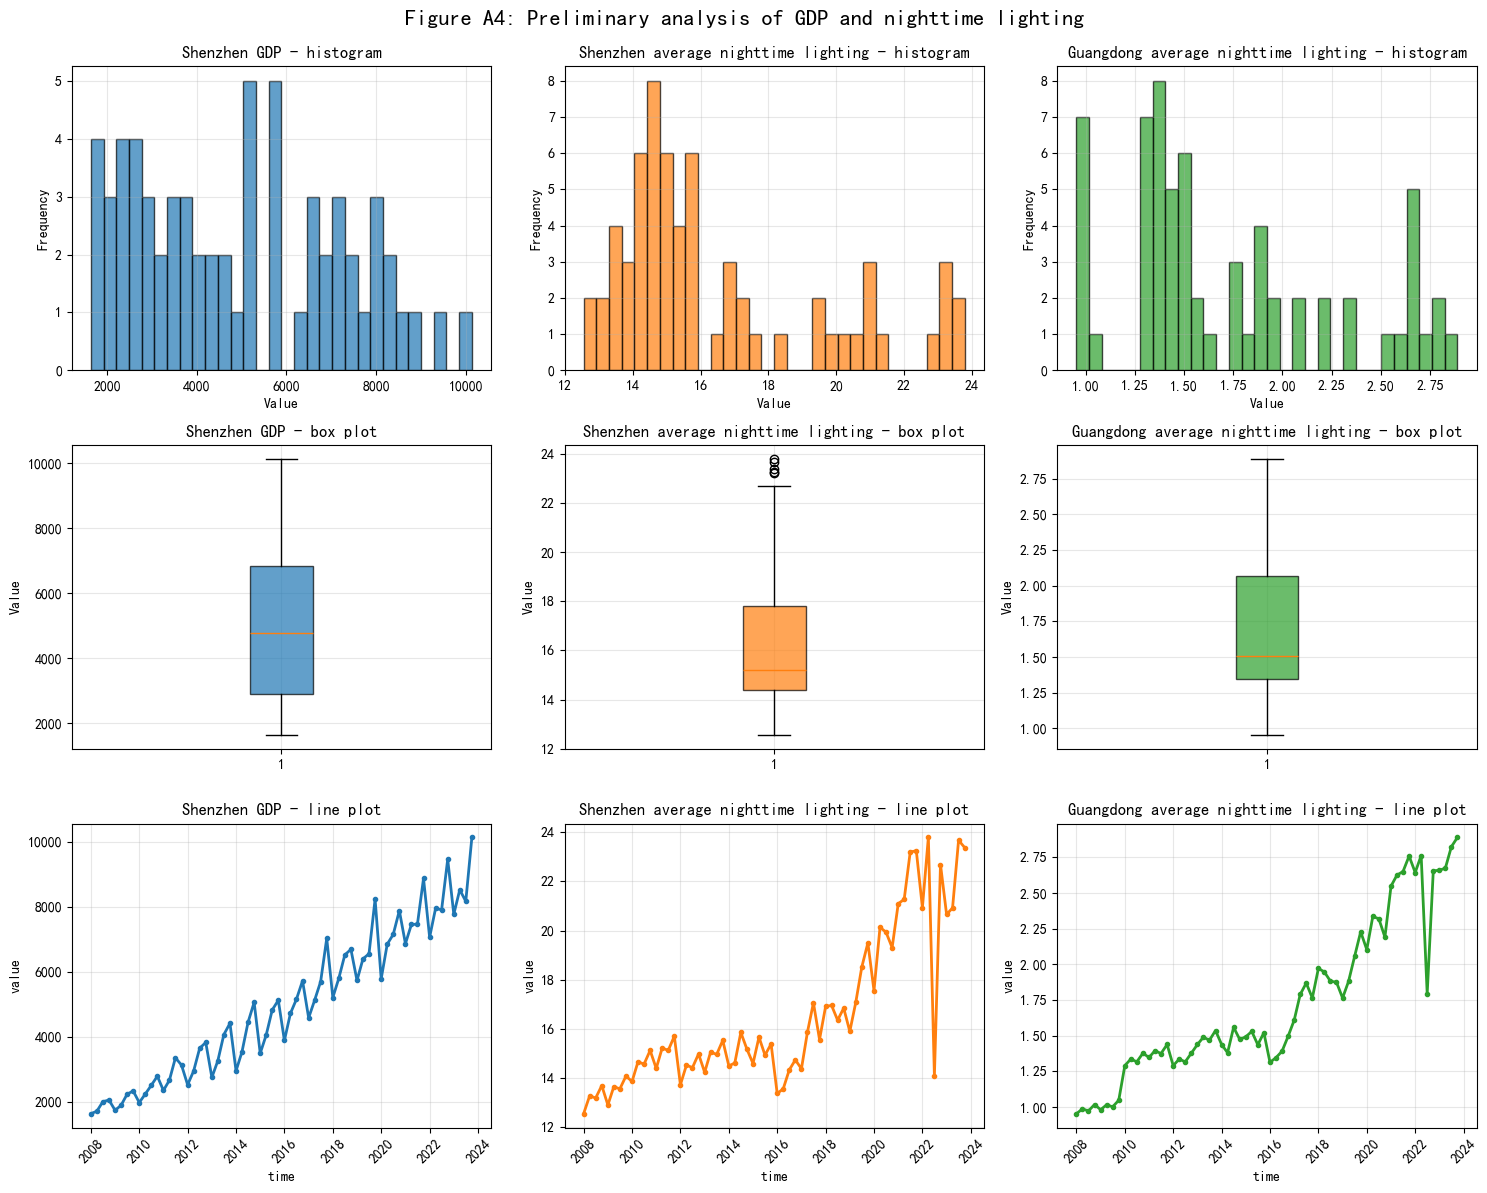

In [16]:
# 三个变量的直方图、箱线图和折线图
def analyze_variables(df):
    """
    对GDP、城市灯光、地区灯光进行直方图、箱线图和折线图分析
    """
    variables = ['GDP', 'city_mean_light', 'region_mean_light']
    existing_vars = [var for var in variables if var in df.columns]
    
    # 变量名映射字典
    var_name_mapping = {
        'GDP': 'Shenzhen GDP',
        'city_mean_light': 'Shenzhen average nighttime lighting',
        'region_mean_light': 'Guangdong average nighttime lighting'
    }
    
    if not existing_vars:
        print("未找到指定的变量列")
        return
    
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建图形 - 3行（直方图、箱线图、折线图）
    fig, axes = plt.subplots(3, len(existing_vars), figsize=(5*len(existing_vars), 12))
    if len(existing_vars) == 1:
        axes = axes.reshape(-1, 1)
    
    # 添加主标题
    fig.suptitle('Figure A4: Preliminary analysis of GDP and nighttime lighting', 
                 fontsize=16, fontweight='bold', y=0.99)
    
    for i, var in enumerate(existing_vars):
        data = df[var].dropna()
        display_name = var_name_mapping.get(var, var)
        
        # 1. 直方图
        axes[0, i].hist(data, bins=30, alpha=0.7, color=f'C{i}', edgecolor='black')
        axes[0, i].set_title(f'{display_name} - histogram')
        axes[0, i].set_xlabel('Value')
        axes[0, i].set_ylabel('Frequency')
        axes[0, i].grid(True, alpha=0.3)
        
        # 2. 箱线图
        box_plot = axes[1, i].boxplot(data, patch_artist=True)
        box_plot['boxes'][0].set_facecolor(f'C{i}')
        box_plot['boxes'][0].set_alpha(0.7)
        axes[1, i].set_title(f'{display_name} - box plot')
        axes[1, i].set_ylabel('Value')
        axes[1, i].grid(True, alpha=0.3)
        
        # 3. 折线图
        axes[2, i].plot(df['time'], data, color=f'C{i}', linewidth=2, marker='o', markersize=3)
        axes[2, i].set_title(f'{display_name} - line plot')
        axes[2, i].set_xlabel('time')
        axes[2, i].set_ylabel('value')
        axes[2, i].tick_params(axis='x', rotation=45)
        axes[2, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 执行分析
if 'df' in locals():
    analyze_variables(df)
else:
    print("请先运行数据读取单元格")

In [ ]:
# 对三个变量进行对数化处理
def create_log_variables(df):
    """
    对GDP、城市灯光、地区灯光进行对数化处理
    """
    variables = ['GDP', 'city_mean_light', 'region_mean_light']
    log_names = ['ln_gdp', 'ln_city', 'ln_region']
    
    print("对数化处理结果：")
    print("="*50)
    
    for var, log_name in zip(variables, log_names):
        if var in df.columns:
            # 检查是否有非正值
            data = df[var]
            min_val = data.min()
            
            if min_val <= 0:
                print(f"⚠️ {var} 包含非正值 (最小值: {min_val:.4f})")
                print(f"   将进行平移处理: 加上 {abs(min_val) + 1:.4f}")
                df[log_name] = np.log(data - min_val + 1)
            else:
                print(f"✅ {var} 所有值为正，直接取对数")
                df[log_name] = np.log(data)
            
            # 显示处理结果
            print(f"   {var} → {log_name}")
            print(f"   原始范围: {data.min():.4f} - {data.max():.4f}")
            print(f"   对数后范围: {df[log_name].min():.4f} - {df[log_name].max():.4f}")
            print()
        else:
            print(f"❌ 未找到变量: {var}")
    
    # 显示新的数据框信息
    print("更新后的数据框：")
    print(f"列数: {len(df.columns)}")
    print(f"新增列: {[name for name in log_names if name in df.columns]}")
    print(f"\n前5行新增列的数据:")
    new_cols = [name for name in log_names if name in df.columns]
    if new_cols:
        print(df[new_cols].head())
    
    return df

# 执行对数化处理
if 'df' in locals():
    df = create_log_variables(df)
    print("\n" + "="*50)
    print("处理完成！对数化变量已添加到数据框中")
else:
    print("请先运行数据读取单元格")

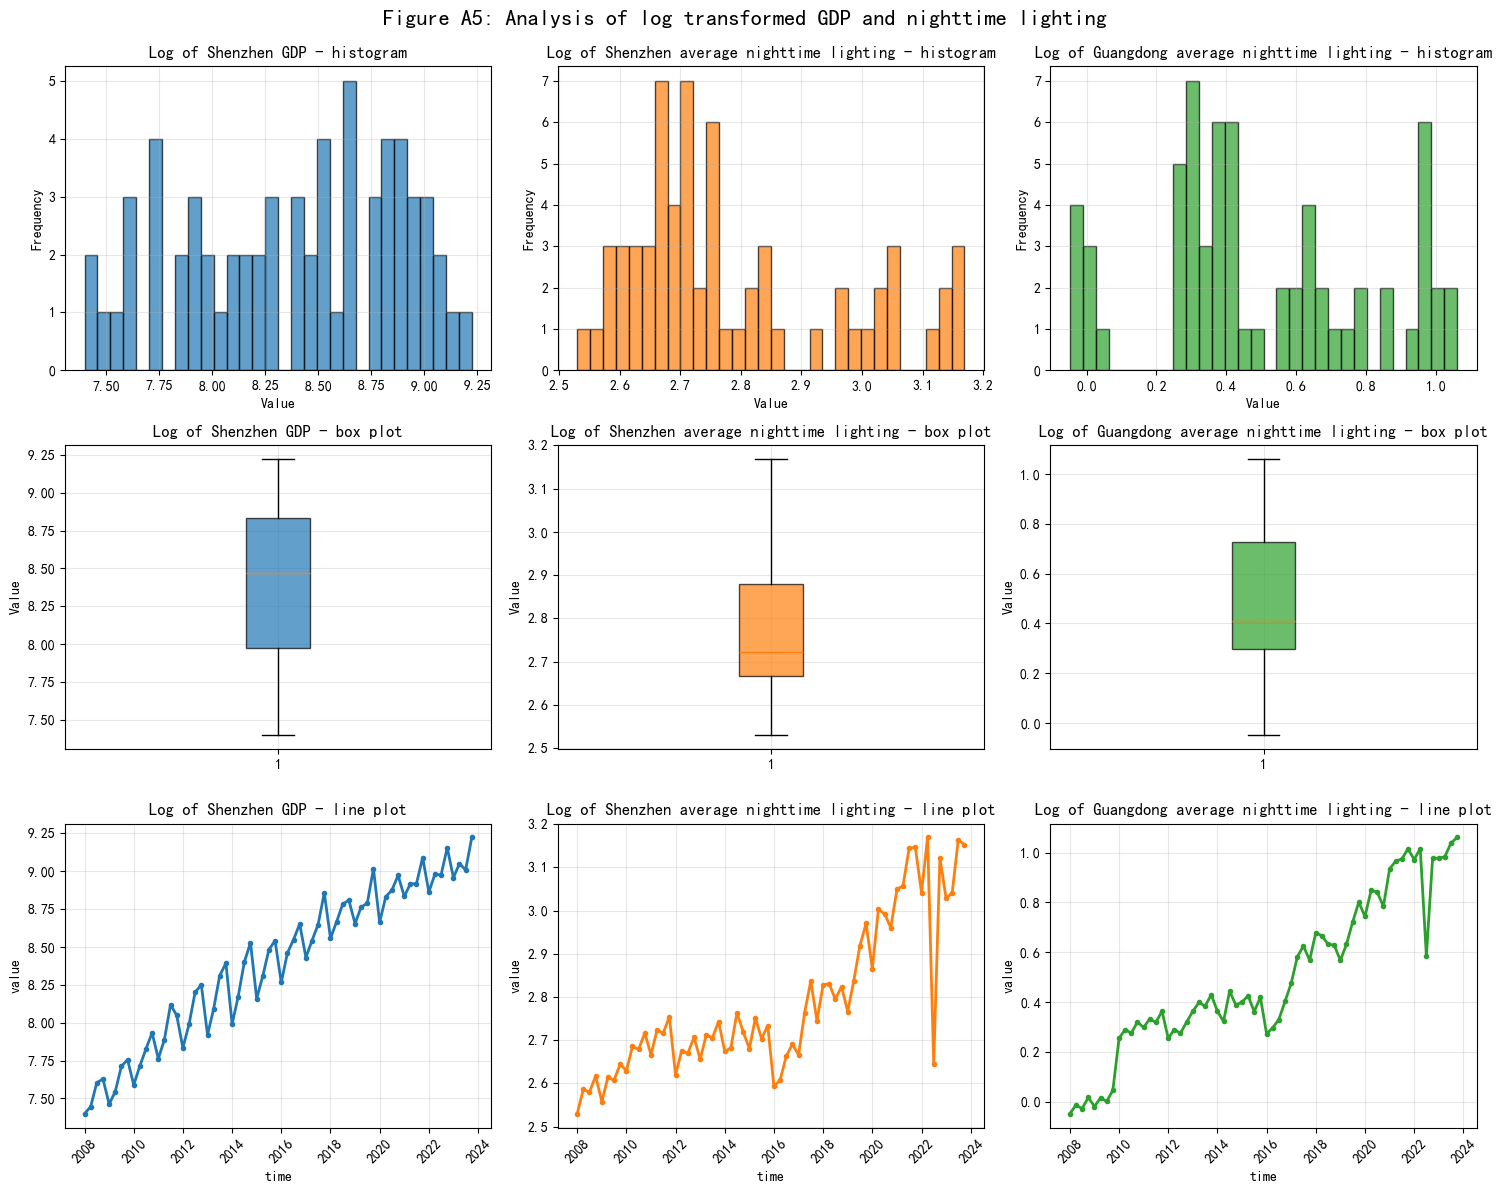

In [22]:
# 三个变量的直方图、箱线图和折线图
def analyze_variables(df):
    """
    对GDP、城市灯光、地区灯光进行直方图、箱线图和折线图分析
    """
    variables = ['ln_gdp', 'ln_city', 'ln_region']
    existing_vars = [var for var in variables if var in df.columns]
    
    # 变量名映射字典
    var_name_mapping = {
        'ln_gdp': 'Log of Shenzhen GDP',
        'ln_city': 'Log of Shenzhen average nighttime lighting',
        'ln_region': 'Log of Guangdong average nighttime lighting'
    }
    
    if not existing_vars:
        print("未找到指定的变量列")
        return
    
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建图形 - 3行（直方图、箱线图、折线图）
    fig, axes = plt.subplots(3, len(existing_vars), figsize=(5*len(existing_vars), 12))
    if len(existing_vars) == 1:
        axes = axes.reshape(-1, 1)
    
    # 添加主标题
    fig.suptitle('Figure A5: Analysis of log transformed GDP and nighttime lighting', 
                 fontsize=16, fontweight='bold', y=0.99)
    
    for i, var in enumerate(existing_vars):
        data = df[var].dropna()
        display_name = var_name_mapping.get(var, var)
        
        # 1. 直方图
        axes[0, i].hist(data, bins=30, alpha=0.7, color=f'C{i}', edgecolor='black')
        axes[0, i].set_title(f'{display_name} - histogram')
        axes[0, i].set_xlabel('Value')
        axes[0, i].set_ylabel('Frequency')
        axes[0, i].grid(True, alpha=0.3)
        
        # 2. 箱线图
        box_plot = axes[1, i].boxplot(data, patch_artist=True)
        box_plot['boxes'][0].set_facecolor(f'C{i}')
        box_plot['boxes'][0].set_alpha(0.7)
        axes[1, i].set_title(f'{display_name} - box plot')
        axes[1, i].set_ylabel('Value')
        axes[1, i].grid(True, alpha=0.3)
        
        # 3. 折线图
        axes[2, i].plot(df['time'], data, color=f'C{i}', linewidth=2, marker='o', markersize=3)
        axes[2, i].set_title(f'{display_name} - line plot')
        axes[2, i].set_xlabel('time')
        axes[2, i].set_ylabel('value')
        axes[2, i].tick_params(axis='x', rotation=45)
        axes[2, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 执行分析
if 'df' in locals():
    analyze_variables(df)
else:
    print("请先运行数据读取单元格")

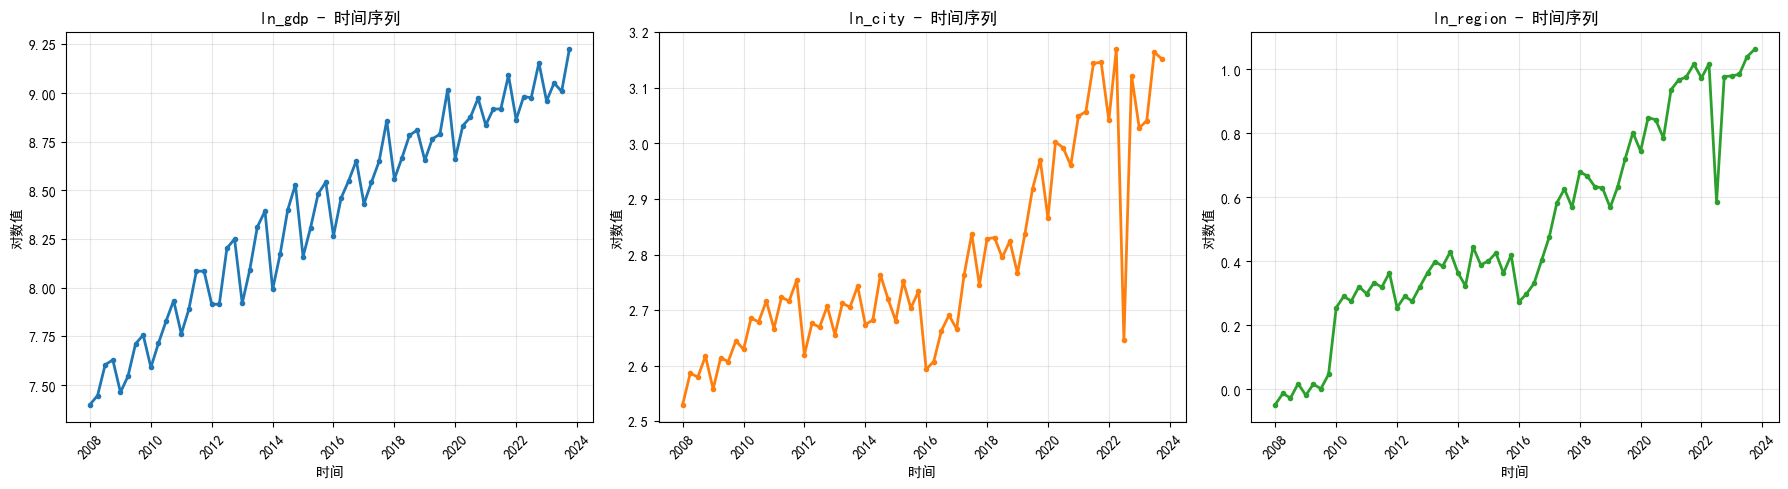

In [17]:
# 对数化变量的折线图和统计描述
log_variables = ['ln_gdp', 'ln_city', 'ln_region']
existing_log_vars = [var for var in log_variables if var in df.columns]

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 绘制折线图
fig, axes = plt.subplots(1, len(existing_log_vars), figsize=(6*len(existing_log_vars), 5))
if len(existing_log_vars) == 1:
    axes = [axes]

for i, var in enumerate(existing_log_vars):
    data = df[var].dropna()

    # 折线图
    axes[i].plot(df['time'], data, color=f'C{i}', linewidth=2, marker='o', markersize=3)
    axes[i].set_title(f'{var} - 时间序列')
    axes[i].set_xlabel('时间')
    axes[i].set_ylabel('对数值')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## seasonal test

In [25]:
# get quaeter dummy
df['quarter'] = df['time'].dt.quarter
quarter_dummies = pd.get_dummies(df['quarter'], prefix='Q', drop_first=True)

# add dummy into PC
df_with_dummies = df.join(quarter_dummies)

print("DataFrame with quarter dummies added:")
display(df_with_dummies.tail())

DataFrame with quarter dummies added:


,time,GDP_4cum,city_mean_light,region_mean_light,title,website,Year,Month,GDP,ln_gdp,ln_city,ln_region,city_prop,region_prop,city_yearly_sum,region_yearly_sum,quarter,Q_2,Q_3,Q_4
59,2022-10-01,32387.68,22.685454,2.654705,2022年深圳经济运行情况,https://tjj.sz.gov.cn/zwgk/zfxxgkml/tjsj/tjfx/...,2022,10,9462.59,9.155101,3.121724,0.976333,0.278325,0.269376,NaN,NaN,4,False,False,True
60,2023-01-01,7772.19,20.656377,2.659478,2023年一季度深圳经济运行情况,https://tjj.sz.gov.cn/zwgk/zfxxgkml/tjsj/tjfx/...,2023,1,7772.19,8.958307,3.028024,0.978130,0.233085,0.240749,NaN,NaN,1,False,False,False
61,2023-04-01,16297.60,20.919221,2.673637,2023年上半年深圳经济运行情况,https://tjj.sz.gov.cn/zwgk/zfxxgkml/tjsj/tjfx/...,2023,4,8525.41,9.050806,3.040668,0.983440,0.236051,0.242031,NaN,NaN,2,True,False,False
62,2023-07-01,24468.25,23.671801,2.823828,2023年前三季度深圳经济运行情况,https://tjj.sz.gov.cn/zwgk/zfxxgkml/tjsj/tjfx/...,2023,7,8170.65,9.008304,3.164284,1.038093,0.267110,0.255627,NaN,NaN,3,False,True,False
63,2023-10-01,34606.40,23.374365,2.889727,2023年深圳经济运行情况,https://tjj.sz.gov.cn/zwgk/zfxxgkml/tjsj/tjfx/...,2023,10,10138.15,9.224061,3.151640,1.061162,0.263754,0.261593,NaN,NaN,4,False,False,True


In [26]:
import statsmodels.api as sm
import pandas as pd
import locale

# Set locale to English to ensure English output
try:
    locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
except:
    try:
        locale.setlocale(locale.LC_ALL, 'English_United States.1252')
    except:
        pass  # Keep default if setting fails

# Define dependent (PCs) and independent (quarter dummies) variables
dependent_variables = ['ln_gdp', 'ln_city', 'ln_region']
independent_variables = ['Q_2', 'Q_3', 'Q_4']

print("Seasonal Test Results:")

# Perform regression for each principal component
for pc_col in dependent_variables:
    print(f"\n--- Regression for {pc_col} ---")

    # Prepare data, dropping rows with NaNs in relevant columns
    # Explicitly convert boolean dummy variables to integers (0 or 1)
    temp_df = df_with_dummies[[pc_col] + independent_variables].copy().dropna()
    for col in independent_variables:
        if col in temp_df.columns:
            temp_df[col] = temp_df[col].astype(int)

    if temp_df.empty:
        print("No data available for regression after dropping NaNs.")
        continue

    # Add a constant and fit OLS model
    X = sm.add_constant(temp_df[independent_variables])
    y = temp_df[pc_col]

    try:
        model = sm.OLS(y, X).fit()
        
        # Print summary with English formatting
        summary_str = str(model.summary())
        # Replace any potential Chinese characters in the summary
        summary_str = summary_str.replace('周四', 'Thu').replace('7月', 'Jul')
        print(summary_str)

        # Perform and print F-test result
        # Ensure the variables for the F-test exist in the model
        f_test_vars = [var for var in independent_variables if var in model.params.index]
        if f_test_vars:
            f_test = model.f_test(f_test_vars)
            # Handle both scalar and array cases for p-value
            if hasattr(f_test.pvalue, '__len__') and len(f_test.pvalue.shape) > 0:
                p_value = f_test.pvalue[0][0] if f_test.pvalue.ndim > 1 else f_test.pvalue[0]
            else:
                p_value = float(f_test.pvalue)
            
            print(f"F-test ({', '.join(f_test_vars)} p-value): {p_value:.4f}")

            alpha = 0.05
            conclusion = "statistically significant seasonal effect." if p_value < alpha else "no statistically significant seasonal effect."
            print(f"Conclusion: {conclusion}")
        else:
            print("No dummy variables included in the model for F-test.")

    except Exception as e:
        print(f"Error during regression or F-test for {pc_col}: {e}")

print("\nSeasonal Test completed.")

Seasonal Test Results:

--- Regression for ln_gdp ---
                            OLS Regression Results                            
Dep. Variable:                 ln_gdp   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.400
Date:                Sat, 09 Aug 2025   Prob (F-statistic):              0.252
Time:                        03:37:03   Log-Likelihood:                -44.640
No. Observations:                  64   AIC:                             97.28
Df Residuals:                      60   BIC:                             105.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

Seasonal Strength Analysis

=== Log of Shenzhen GDP Analysis ===
Seasonal Strength: 0.8339
Seasonal Component Std: 0.1020
Seasonal Component Range: 0.2712
Seasonality Assessment: Strong Seasonality

=== Log of Shenzhen average nighttime lighting Analysis ===
Seasonal Strength: 0.1302
Seasonal Component Std: 0.0229
Seasonal Component Range: 0.0602
Seasonality Assessment: Weak Seasonality

=== Log of Guangdong average nighttime lighting Analysis ===
Seasonal Strength: 0.0638
Seasonal Component Std: 0.0142
Seasonal Component Range: 0.0365
Seasonality Assessment: Weak Seasonality


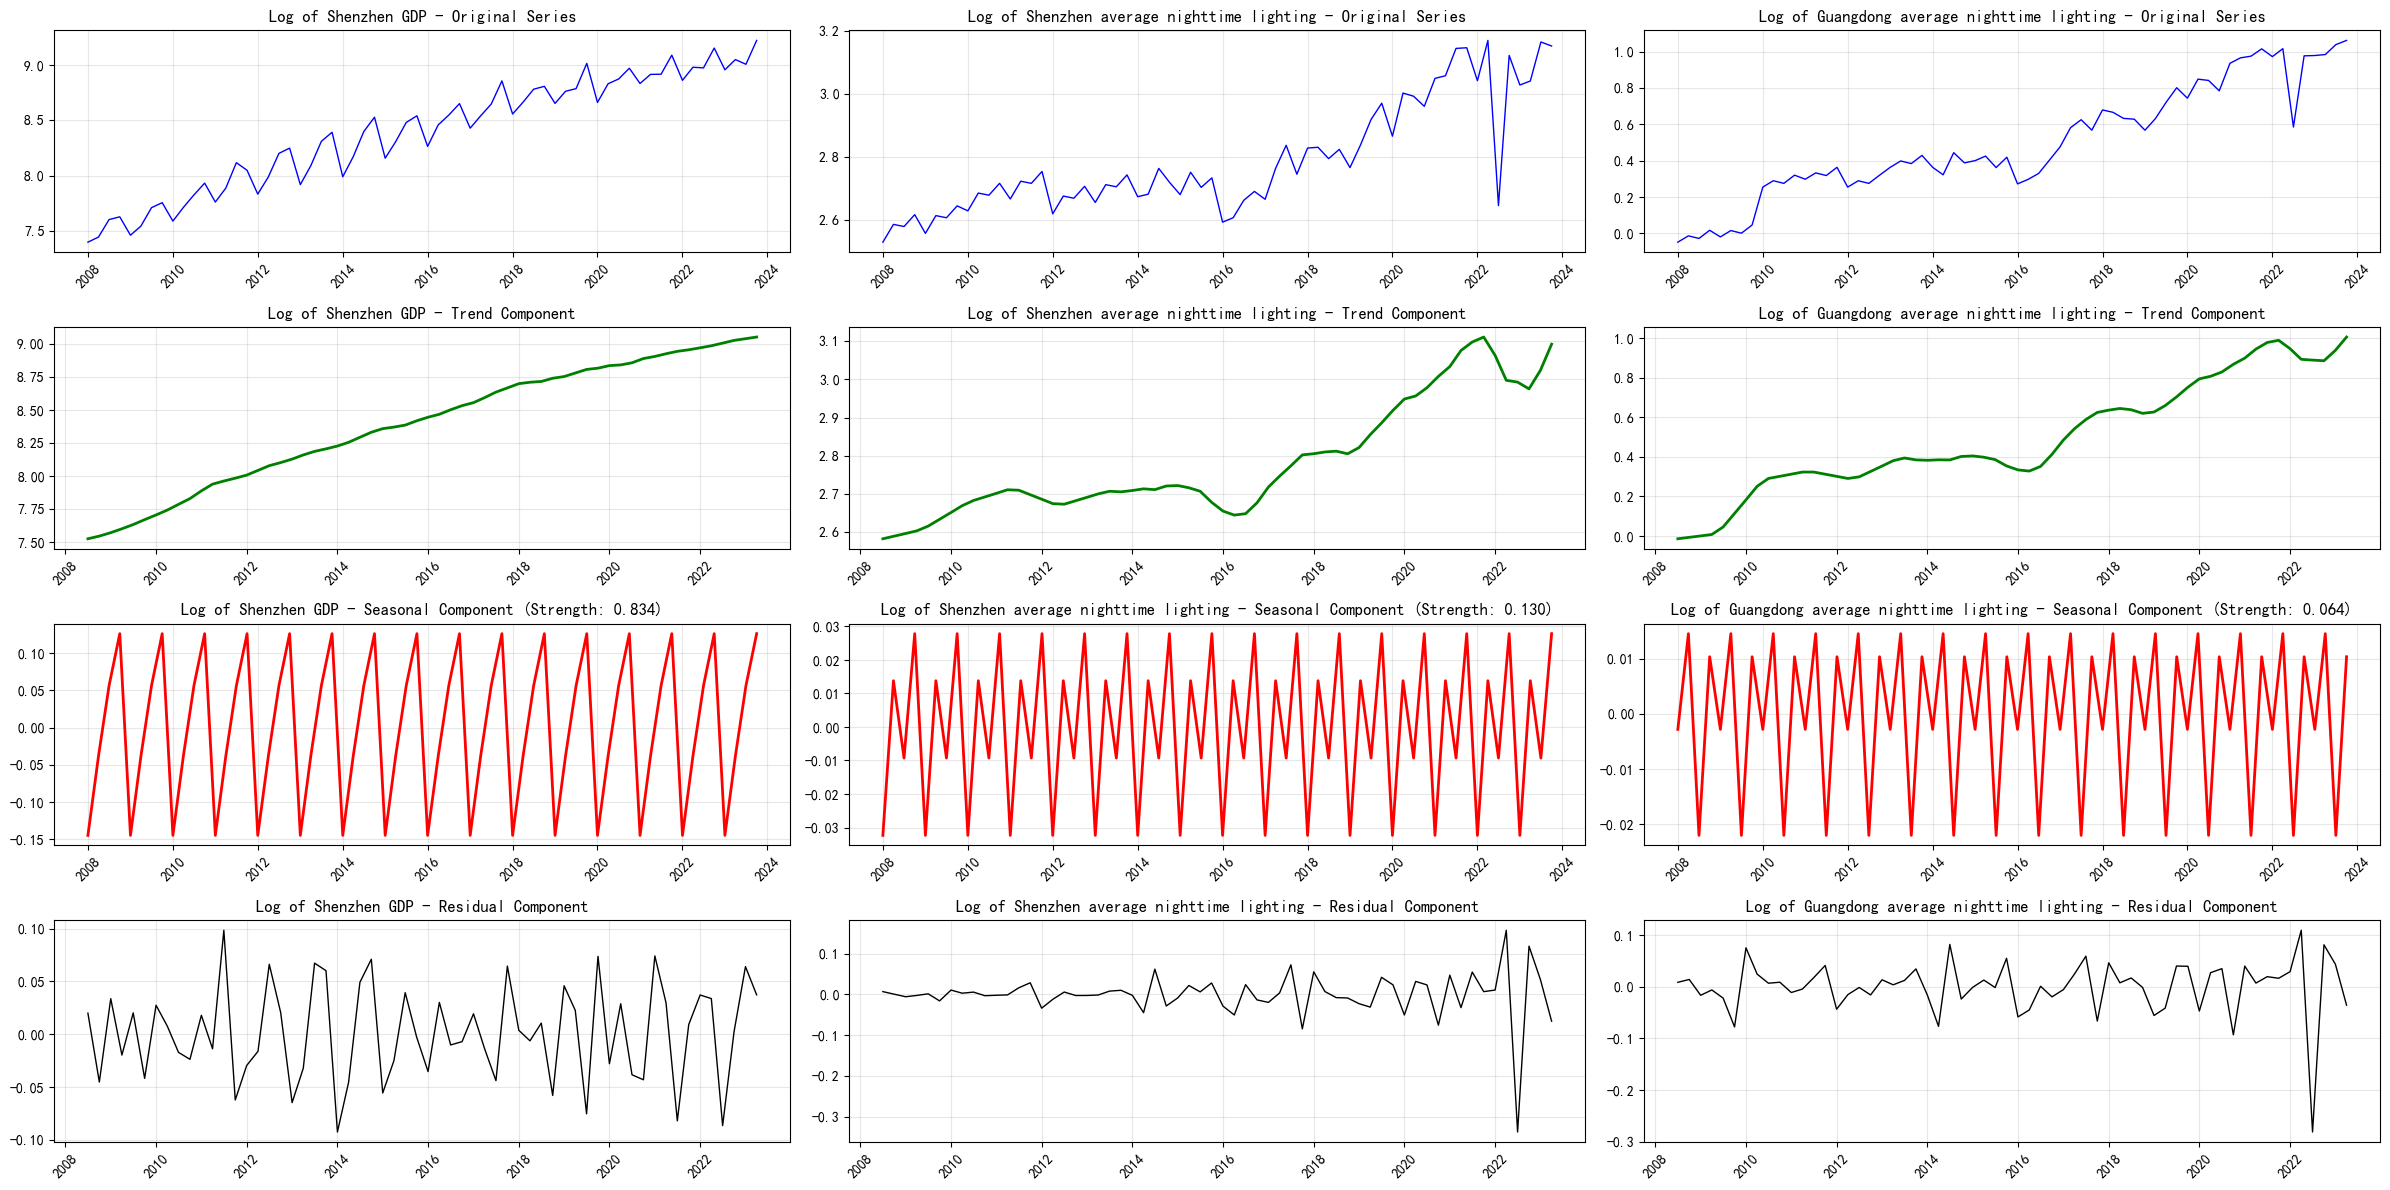


Seasonal Strength Comparison Summary
Log of Shenzhen GDP                 | Seasonal Strength: 0.8339 | Strong Seasonality
Log of Shenzhen average nighttime lighting | Seasonal Strength: 0.1302 | Weak Seasonality
Log of Guangdong average nighttime lighting | Seasonal Strength: 0.0638 | Weak Seasonality


In [34]:
# Seasonal strength analysis for log-transformed variables
log_variables = ['ln_gdp', 'ln_city', 'ln_region']
existing_log_vars = [var for var in log_variables if var in df.columns]

# Variable name mapping
var_name_mapping = {
    'ln_gdp': 'Log of Shenzhen GDP',
    'ln_city': 'Log of Shenzhen average nighttime lighting',
    'ln_region': 'Log of Guangdong average nighttime lighting'
}

# Set Chinese font
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# Seasonal strength analysis function
def analyze_seasonal_strength(df, log_variables):
    """
    Analyze seasonal strength of log-transformed variables
    """
    print("="*60)
    print("Seasonal Strength Analysis")
    print("="*60)
    
    # Set time as index for seasonal decomposition
    df_temp = df.set_index('time').copy()
    
    seasonal_results = {}
    
    for var in log_variables:
        if var in df.columns:
            var_display = var_name_mapping.get(var, var)
            print(f"\n=== {var_display} Analysis ===")
            
            # Get data and remove missing values
            series = df_temp[var].dropna()
            
            # Check data length
            if len(series) < 8:  # Quarterly data needs at least 8 observations (2 years)
                print(f"⚠️ {var_display} insufficient data length, cannot perform seasonal decomposition")
                continue
            
            try:
                # Seasonal decomposition (quarterly data, period=4)
                decomposition = seasonal_decompose(series, model='additive', period=4)
                
                # Calculate seasonal strength indicators
                seasonal_component = decomposition.seasonal
                residual_component = decomposition.resid.dropna()
                
                # Seasonal strength = seasonal component variance / residual component variance
                seasonal_var = np.var(seasonal_component)
                residual_var = np.var(residual_component)
                seasonal_strength = seasonal_var / (seasonal_var + residual_var)
                
                # Other seasonal indicators
                seasonal_range = seasonal_component.max() - seasonal_component.min()
                seasonal_std = np.std(seasonal_component)
                
                print(f"Seasonal Strength: {seasonal_strength:.4f}")
                print(f"Seasonal Component Std: {seasonal_std:.4f}")
                print(f"Seasonal Component Range: {seasonal_range:.4f}")
                
                # Interpret seasonal strength
                if seasonal_strength > 0.6:
                    strength_desc = "Strong Seasonality"
                elif seasonal_strength > 0.3:
                    strength_desc = "Moderate Seasonality"
                else:
                    strength_desc = "Weak Seasonality"
                
                print(f"Seasonality Assessment: {strength_desc}")
                
                # Save results
                seasonal_results[var] = {
                    'seasonal_strength': seasonal_strength,
                    'seasonal_std': seasonal_std,
                    'seasonal_range': seasonal_range,
                    'description': strength_desc,
                    'decomposition': decomposition,
                    'display_name': var_display
                }
                
            except Exception as e:
                print(f"❌ {var_display} seasonal decomposition failed: {str(e)}")
    
    return seasonal_results

# Seasonal decomposition visualization function
def plot_seasonal_decomposition(seasonal_results):
    """
    Plot seasonal decomposition charts
    """
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    n_vars = len(seasonal_results)
    if n_vars == 0:
        print("No seasonal decomposition results to plot")
        return
    
    fig, axes = plt.subplots(4, n_vars, figsize=(8*n_vars, 12))
    if n_vars == 1:
        axes = axes.reshape(-1, 1)
    
    for i, (var, result) in enumerate(seasonal_results.items()):
        decomp = result['decomposition']
        var_display = result['display_name']
        
        # Original series
        axes[0, i].plot(decomp.observed.index, decomp.observed.values, 'b-', linewidth=1)
        axes[0, i].set_title(f'{var_display} - Original Series')
        axes[0, i].grid(True, alpha=0.3)
        
        # Trend component
        axes[1, i].plot(decomp.trend.index, decomp.trend.values, 'g-', linewidth=2)
        axes[1, i].set_title(f'{var_display} - Trend Component')
        axes[1, i].grid(True, alpha=0.3)
        
        # Seasonal component
        axes[2, i].plot(decomp.seasonal.index, decomp.seasonal.values, 'r-', linewidth=2)
        axes[2, i].set_title(f'{var_display} - Seasonal Component (Strength: {result["seasonal_strength"]:.3f})')
        axes[2, i].grid(True, alpha=0.3)
        
        # Residual component
        axes[3, i].plot(decomp.resid.index, decomp.resid.values, 'k-', linewidth=1)
        axes[3, i].set_title(f'{var_display} - Residual Component')
        axes[3, i].grid(True, alpha=0.3)
        
        # Rotate x-axis labels
        for j in range(4):
            axes[j, i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Execute seasonal strength analysis
log_variables = ['ln_gdp', 'ln_city', 'ln_region']
existing_log_vars = [var for var in log_variables if var in df.columns]

if existing_log_vars:
    # Analyze seasonal strength
    seasonal_results = analyze_seasonal_strength(df, existing_log_vars)
    
    # Plot seasonal decomposition
    if seasonal_results:
        plot_seasonal_decomposition(seasonal_results)
        
        # Summary comparison
        print("\n" + "="*60)
        print("Seasonal Strength Comparison Summary")
        print("="*60)
        for var, result in seasonal_results.items():
            var_display = result['display_name']
            print(f"{var_display:35} | Seasonal Strength: {result['seasonal_strength']:.4f} | {result['description']}")
    else:
        print("All seasonal decomposition failed")
else:
    print("Log-transformed variables not found, please run log transformation first")

### seasonal adjust

In [4]:
df.head

<bound method NDFrame.head of          time  GDP_4cum  city_mean_light  region_mean_light  \
0  2008-01-01   1634.65        12.553247           0.953015   
1  2008-04-01   3346.63        13.280818           0.986813   
2  2008-07-01   5351.74        13.191190           0.972665   
3  2008-10-01   7407.66        13.697327           1.017466   
4  2009-01-01   1740.90        12.906907           0.980980   
..        ...       ...              ...                ...   
59 2022-10-01  32387.68        22.685454           2.654705   
60 2023-01-01   7772.19        20.656377           2.659478   
61 2023-04-01  16297.60        20.919221           2.673637   
62 2023-07-01  24468.25        23.671801           2.823828   
63 2023-10-01  34606.40        23.374365           2.889727   

                title                                            website  \
0                (填补)                                               none   
1                (填补)                                        

In [5]:

from statsmodels.tsa.seasonal import STL
import pandas as pd

print("=== Seasonal Adjustment (STL-based) ===")

if 'ln_gdp' in df.columns:
    # 准备时间序列数据
    df_temp = df.set_index('time')
    ln_gdp_series = df_temp['ln_gdp'].dropna()
    
    # 使用STL进行季节分解（模拟X-12效果）
    stl = STL(ln_gdp_series, period=4, robust=True).fit()
    
    # 季节调整序列 = 原序列 - 季节成分
    ln_gdp_sa = stl.observed - stl.seasonal
    seasonal_factors = stl.seasonal
    
    # 映射回原DataFrame
    df['ln_gdp_sa'] = df['time'].map(ln_gdp_sa.to_dict())
    df['ln_gdp_seasonal_factor'] = df['time'].map(seasonal_factors.to_dict())
    
    print(f"✅ 完成！新增列: ln_gdp_sa, ln_gdp_seasonal_factor")
    print(f"季节因子范围: {seasonal_factors.min():.4f} to {seasonal_factors.max():.4f}")
else:
    print("❌ 未找到ln_gdp列")

=== Seasonal Adjustment (STL-based) ===
✅ 完成！新增列: ln_gdp_sa, ln_gdp_seasonal_factor
季节因子范围: -0.1797 to 0.1463


In [6]:
# 保存STL去季节器（简洁版）
import pickle

# 保存STL模型和季节因子
stl_deseasonalizer = {
    'seasonal_factors': stl.seasonal,  # 季节因子序列
    'quarterly_averages': stl.seasonal.groupby(stl.seasonal.index.quarter).mean(),  # 各季度平均季节因子
    'model_params': {'period': 4, 'robust': True}  # 模型参数
}

# 保存到文件
with open(r"C:\Users\huawei\OneDrive\桌面\stl_deseasonalizer.pkl", 'wb') as f:
    pickle.dump(stl_deseasonalizer, f)

print("✅ STL去季节器已保存！")
print(f"📊 各季度平均季节因子: {stl_deseasonalizer['quarterly_averages'].to_dict()}")


✅ STL去季节器已保存！
📊 各季度平均季节因子: {1: -0.11735833627936566, 2: -0.04065096198361591, 3: 0.048853816355181455, 4: 0.1094974786833777}


1. 季节模式外推法（推荐）-- 季度平均值
2. 最后一个周期重复法（简单）

每次迭代使用50个季度作为训练数据，接下来5个季度作为测试数据
窗口不断向前滑动，模拟真实的预测场景

计算训练期内每个季度的平均季节因子
预测值 = 趋势均值 + 对应季度的平均季节因子

计算训练期内每个季度的平均季节因子
预测值 = 趋势均值 + 对应季度的平均季节因子

In [7]:
# 季节因子预测方法比较 (直接比较季节因子)
import numpy as np
from sklearn.metrics import mean_squared_error

# 确保df有quarter列
if 'quarter' not in df.columns:
    df['quarter'] = df['time'].dt.quarter

mse_results = {'extrap': [], 'repeat': []}

# 滚动窗口验证
for i in range(len(df) - 45):
    # 训练期：40个季度，测试期：5个季度
    train_data = df.iloc[i:i+40].copy()
    test_data = df.iloc[i+40:i+45].copy()
    
    # 方法1: 季度平均值外推法
    # 计算训练期各季度季节因子的平均值
    quarterly_avg = train_data.groupby('quarter')['ln_gdp_seasonal_factor'].mean()
    pred_seasonal_1 = [quarterly_avg.get(q, 0) for q in test_data['quarter']]
    
    # 方法2: 最后周期重复法
    # 使用训练期最后4个季度的季节因子
    last_4_quarters = train_data.iloc[-4:].set_index('quarter')['ln_gdp_seasonal_factor']
    pred_seasonal_2 = [last_4_quarters.get(q, 0) for q in test_data['quarter']]
    
    # 计算与真实季节因子的MSE
    true_seasonal = test_data['ln_gdp_seasonal_factor'].values
    mse_results['extrap'].append(mean_squared_error(true_seasonal, pred_seasonal_1))
    mse_results['repeat'].append(mean_squared_error(true_seasonal, pred_seasonal_2))

# 结果
avg_mse1, avg_mse2 = np.mean(mse_results['extrap']), np.mean(mse_results['repeat'])
print(f"季节模式外推法 MSE: {avg_mse1:.6f}")
print(f"最后周期重复法 MSE: {avg_mse2:.6f}")
print(f"最优方法: {'季节模式外推法' if avg_mse1 < avg_mse2 else '最后周期重复法'}")

季节模式外推法 MSE: 0.002634
最后周期重复法 MSE: 0.000203
最优方法: 最后周期重复法


In [8]:

# 滚动窗口验证
mse_results = {'extrap': [], 'repeat': []}
for i in range(len(df) - 50):
    train_df = df.iloc[i:i+45].set_index('time')
    test_df = df.iloc[i+45:i+50]
    
    # 方法1: 季度平均值外推法
    # 计算训练期各季度季节因子的平均值
    quarterly_avg = train_data.groupby('quarter')['ln_gdp_seasonal_factor'].mean()
    pred_seasonal_1 = [quarterly_avg.get(q, 0) for q in test_data['quarter']]
    
    # 方法2: 最后周期重复法
    # 使用训练期最后4个季度的季节因子
    last_4_quarters = train_data.iloc[-4:].set_index('quarter')['ln_gdp_seasonal_factor']
    pred_seasonal_2 = [last_4_quarters.get(q, 0) for q in test_data['quarter']]
    
    # 计算与真实季节因子的MSE
    true_seasonal = test_data['ln_gdp_seasonal_factor'].values
    mse_results['extrap'].append(mean_squared_error(true_seasonal, pred_seasonal_1))
    mse_results['repeat'].append(mean_squared_error(true_seasonal, pred_seasonal_2))

# 结果
avg_mse1, avg_mse2 = np.mean(mse_results['extrap']), np.mean(mse_results['repeat'])
print(f"季节模式外推法 MSE: {avg_mse1:.6f}")
print(f"最后周期重复法 MSE: {avg_mse2:.6f}")
print(f"最优方法: {'季节模式外推法' if avg_mse1 < avg_mse2 else '最后周期重复法'}")


季节模式外推法 MSE: 0.004499
最后周期重复法 MSE: 0.000348
最优方法: 最后周期重复法

最后周期重复法 MSE: 0.000348
最优方法: 最后周期重复法


In [9]:


mse_results = {'extrap': [], 'repeat': []}
for i in range(len(df) - 55):
    train_df = df.iloc[i:i+50].set_index('time')
    test_df = df.iloc[i+50:i+55]
    
    # 方法1: 季度平均值外推法
    # 计算训练期各季度季节因子的平均值
    quarterly_avg = train_df.groupby('quarter')['ln_gdp_seasonal_factor'].mean()
    pred_seasonal_1 = [quarterly_avg.get(q, 0) for q in test_df['quarter']]
    
    # 方法2: 最后周期重复法
    # 使用训练期最后4个季度的季节因子
    last_4_quarters = train_df.iloc[-4:].set_index('quarter')['ln_gdp_seasonal_factor']
    pred_seasonal_2 = [last_4_quarters.get(q, 0) for q in test_df['quarter']]
    
    # 计算与真实季节因子的MSE
    true_seasonal = test_df['ln_gdp_seasonal_factor'].values
    mse_results['extrap'].append(mean_squared_error(true_seasonal, pred_seasonal_1))
    mse_results['repeat'].append(mean_squared_error(true_seasonal, pred_seasonal_2))

# 结果
avg_mse1, avg_mse2 = np.mean(mse_results['extrap']), np.mean(mse_results['repeat'])
print(f"季节模式外推法 MSE: {avg_mse1:.6f}")
print(f"最后周期重复法 MSE: {avg_mse2:.6f}")
print(f"最优方法: {'季节模式外推法' if avg_mse1 < avg_mse2 else '最后周期重复法'}")

季节模式外推法 MSE: 0.003280
最后周期重复法 MSE: 0.000200
最优方法: 最后周期重复法

最后周期重复法 MSE: 0.000200
最优方法: 最后周期重复法


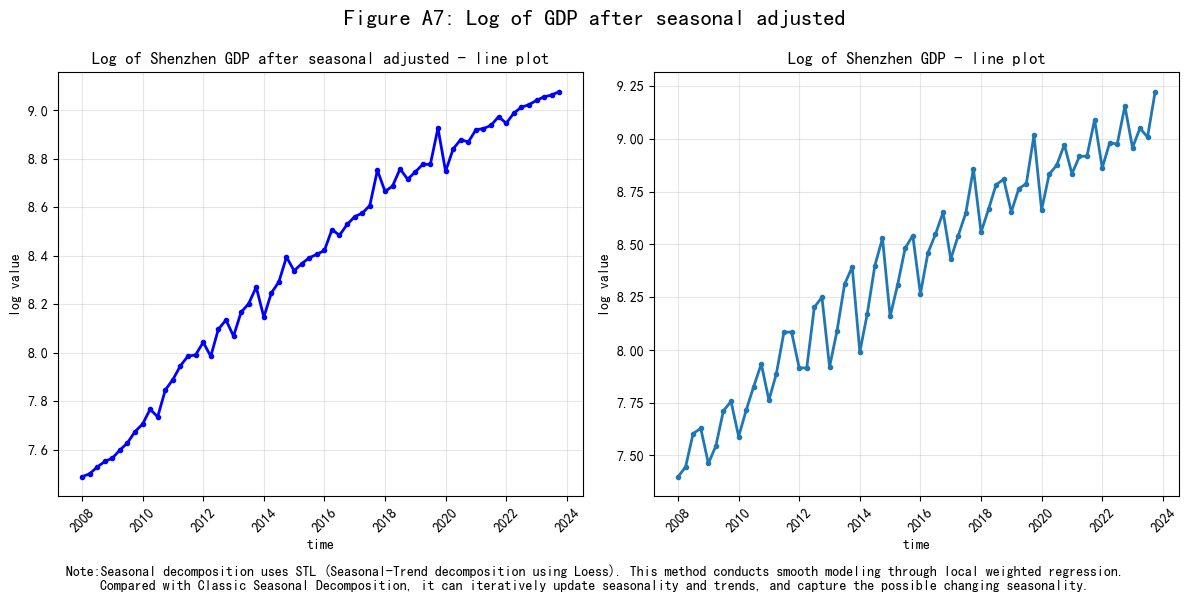

In [10]:
# 对数化变量的折线图和统计描述
log_variables = ['ln_gdp_sa', 'ln_gdp']
existing_log_vars = [var for var in log_variables if var in df.columns]

# 变量名映射字典
var_name_mapping = {
    'ln_gdp_sa': 'Log of Shenzhen GDP after seasonal adjusted',
    'ln_gdp': 'Log of Shenzhen GDP'
}

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 绘制折线图
fig, axes = plt.subplots(1, len(existing_log_vars), figsize=(6*len(existing_log_vars), 6))
if len(existing_log_vars) == 1:
    axes = [axes]

# 添加主标题
fig.suptitle('Figure A7: Log of GDP after seasonal adjusted', 
             fontsize=16, fontweight='bold', y=0.99)

for i, var in enumerate(existing_log_vars):
    data = df[var].dropna()
    display_name = var_name_mapping.get(var, var)

    # 设置颜色：ln_gdp_sa用纯蓝色，ln_gdp用灰蓝色
    if var == 'ln_gdp_sa':
        color = 'blue'
    elif var == 'ln_gdp':
        color = 'C0'  # 默认的灰蓝色
    else:
        color = f'C{i}'

    # 折线图
    axes[i].plot(df['time'], data, color=color, linewidth=2, marker='o', markersize=3)
    axes[i].set_title(f'{display_name} - line plot')
    axes[i].set_xlabel('time')
    axes[i].set_ylabel('log value')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()

# 添加注释
fig.text(0.5, 0.02, 
         'Note:Seasonal decomposition uses STL (Seasonal-Trend decomposition using Loess). This method conducts smooth modeling through local weighted regression.\nCompared with Classic Seasonal Decomposition, it can iteratively update seasonality and trends, and capture the possible changing seasonality.',
         ha='center', va='bottom', fontsize=10, style='italic', wrap=True)

plt.subplots_adjust(bottom=0.18)  # 为注释留出空间
plt.show()

## ADF test

In [63]:

import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Ensure PC DataFrame is available
if 'df' in locals() and isinstance(df, pd.DataFrame):
    variables_to_test = ['ln_gdp_sa', 'ln_city', 'ln_region']

    print("--- Full ADF Test Results ---")

    for var in variables_to_test:
        if var in df.columns:
            print(f"\nADF Test for '{var}':")

            # Get the time series data, dropping NaNs if any (ADF test requires no NaNs)
            series = df[var].dropna()

            if len(series) > 0:
                try:
                    # Perform the ADF test
                    # 'ct' includes a constant and a trend
                    # 'c' includes only a constant (often suitable for differenced series)
                    # 'nc' includes neither
                    # Choosing 'c' as a common assumption, adjust if needed
                    # Use 'ct' for 'pc2' to include a trend term
                    regression_type = 'ct' 
                    print(f"  Regression type: '{regression_type}'")
                    adf_test_result = adfuller(series, regression=regression_type)


                    # Extract and print the full results
                    print(f"  ADF Statistic: {adf_test_result[0]:.4f}")
                    print(f"  P-value: {adf_test_result[1]:.4f}")
                    print(f"  Number of Lags Used: {adf_test_result[2]}")
                    print(f"  Number of Observations Used: {adf_test_result[3]}")
                    print("  Critical Values:")
                    for key, value in adf_test_result[4].items():
                        print(f"    {key}: {value:.4f}")

                    # Optional: Print a conclusion based on the p-value
                    alpha = 0.05
                    conclusion = "stationary" if adf_test_result[1] < alpha else "non-stationary"
                    print(f"  Conclusion (at alpha={alpha}): {conclusion}")

                except Exception as e:
                    print(f"  Error during ADF test for '{var}': {e}")
            else:
                print(f"  '{var}' has no data after dropping NaNs.")

    print("\nADF Test task finished.")

else:
    print("DataFrame 'PC' not found or is not a DataFrame. Please ensure 'PC' is loaded.")

--- Full ADF Test Results ---

ADF Test for 'ln_gdp_sa':
  Regression type: 'ct'
  ADF Statistic: -0.4559
  P-value: 0.9851
  Number of Lags Used: 4
  Number of Observations Used: 59
  Critical Values:
    1%: -4.1210
    5%: -3.4877
    10%: -3.1721
  Conclusion (at alpha=0.05): non-stationary

ADF Test for 'ln_city':
  Regression type: 'ct'
  ADF Statistic: -2.5897
  P-value: 0.2846
  Number of Lags Used: 1
  Number of Observations Used: 62
  Critical Values:
    1%: -4.1127
    5%: -3.4838
    10%: -3.1699
  Conclusion (at alpha=0.05): non-stationary

ADF Test for 'ln_region':
  Regression type: 'ct'
  ADF Statistic: -2.8252
  P-value: 0.1878
  Number of Lags Used: 1
  Number of Observations Used: 62
  Critical Values:
    1%: -4.1127
    5%: -3.4838
    10%: -3.1699
  Conclusion (at alpha=0.05): non-stationary

ADF Test task finished.


In [65]:
# 对对数化变量进行一阶差分
def create_diff_variables(df):
    """
    对ln_gdp、ln_city、ln_region进行一阶差分
    """
    print("一阶差分处理：")
    print("="*50)
    
    # 定义要差分的变量
    log_vars = ['ln_gdp_sa', 'ln_city', 'ln_region']
    diff_names = ['dln_gdp_sa', 'dln_city', 'dln_region']
    
    for log_var, diff_name in zip(log_vars, diff_names):
        if log_var in df.columns:
            # 计算一阶差分
            df[diff_name] = df[log_var].diff()
            
            # 统计信息
            original_count = df[log_var].dropna().shape[0]
            diff_count = df[diff_name].dropna().shape[0]
            
            print(f"✅ {log_var} → {diff_name}")
            print(f"   原始数据: {original_count} 个观测")
            print(f"   差分后: {diff_count} 个观测 (丢失{original_count-diff_count}个)")
            print(f"   差分值范围: {df[diff_name].min():.4f} - {df[diff_name].max():.4f}")
            print()
        else:
            print(f"❌ 未找到变量: {log_var}")
    
    # 显示差分后的前几行数据
    print("差分后的前5行数据:")
    diff_cols = [name for name in diff_names if name in df.columns]
    if diff_cols:
        print(df[['time'] + diff_cols].head())
    
    return df

# 执行差分处理
if 'df' in locals() and 'ln_gdp' in df.columns:
    df = create_diff_variables(df)
    print("\n" + "="*50)
    print("差分处理完成！")
else:
    print("请先运行对数化处理")

一阶差分处理：
✅ ln_gdp_sa → dln_gdp_sa
   原始数据: 64 个观测
   差分后: 63 个观测 (丢失1个)
   差分值范围: -0.1816 - 0.1482

✅ ln_city → dln_city
   原始数据: 64 个观测
   差分后: 63 个观测 (丢失1个)
   差分值范围: -0.5235 - 0.4759

✅ ln_region → dln_region
   原始数据: 64 个观测
   差分后: 63 个观测 (丢失1个)
   差分值范围: -0.4312 - 0.3915

差分后的前5行数据:
        time  dln_gdp_sa  dln_city  dln_region
0 2008-01-01         NaN       NaN         NaN
1 2008-04-01    0.021537  0.056341    0.034850
2 2008-07-01    0.030430 -0.006772   -0.014441
3 2008-10-01    0.025043  0.037652    0.045031
4 2009-01-01    0.011370 -0.059438   -0.036519

差分处理完成！


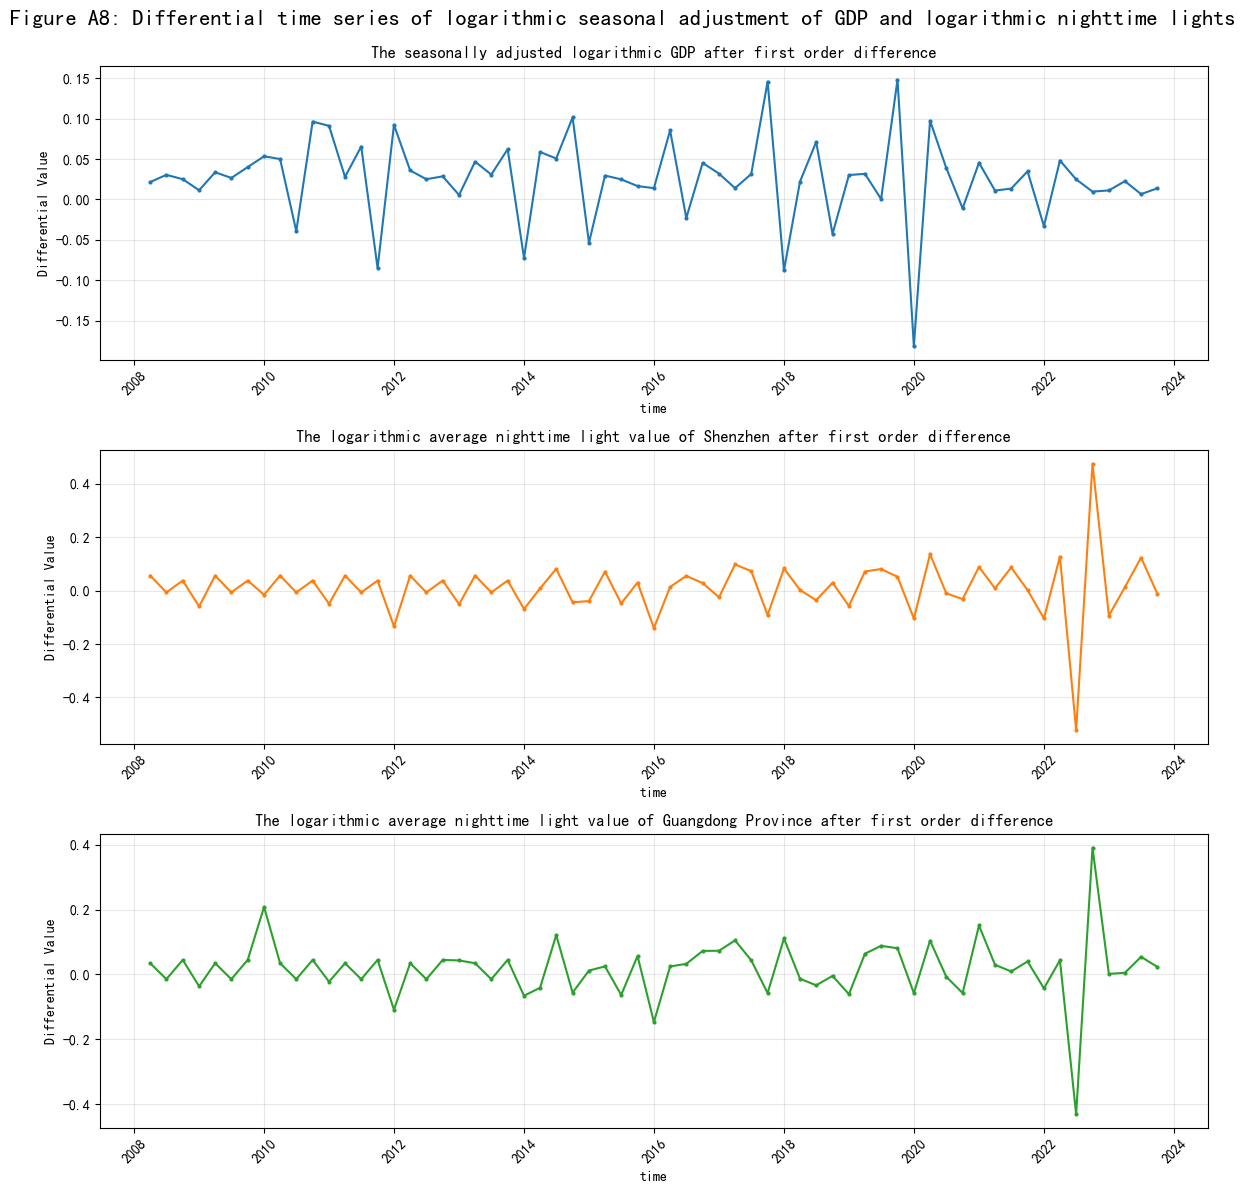

In [78]:
# 差分变量的可视化分析
def plot_diff_variables(df):
    """
    绘制差分变量的时间序列图
    """
    diff_variables = ['dln_gdp_sa', 'dln_city', 'dln_region']
    existing_diff_vars = [var for var in diff_variables if var in df.columns]
    
    # 变量名映射字典
    var_name_mapping = {
        'dln_gdp_sa': 'The seasonally adjusted logarithmic GDP after first order difference',
        'dln_city': 'The logarithmic average nighttime light value of Shenzhen after first order difference',
        'dln_region': 'The logarithmic average nighttime light value of Guangdong Province after first order difference'
    }
    
    if not existing_diff_vars:
        print("未找到差分变量")
        return
    
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建子图
    fig, axes = plt.subplots(len(existing_diff_vars), 1, figsize=(12, 4*len(existing_diff_vars)))
    if len(existing_diff_vars) == 1:
        axes = [axes]
    
    # 添加主标题
    fig.suptitle('Figure A8: Differential time series of logarithmic seasonal adjustment of GDP and logarithmic nighttime lights', 
                 fontsize=16, fontweight='bold', y=0.99)
    
    for i, var in enumerate(existing_diff_vars):
        data = df[var].dropna()
        time_data = df.loc[data.index, 'time'] if 'time' in df.columns else data.index
        display_name = var_name_mapping.get(var, var)
        
        # 绘制差分序列
        axes[i].plot(time_data, data, color=f'C{i}', linewidth=1.5, marker='o', markersize=2)
        axes[i].set_title(f'{display_name}', fontsize=12)
        axes[i].set_xlabel('time')
        axes[i].set_ylabel('Differential Value')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 绘制差分变量图
diff_variables = ['dln_gdp_sa', 'dln_city', 'dln_region']
existing_diff_vars = [var for var in diff_variables if var in df.columns]

if existing_diff_vars:
    plot_diff_variables(df)
else:
    print("请先运行差分处理代码")

In [68]:

import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Ensure PC DataFrame is available
if 'df' in locals() and isinstance(df, pd.DataFrame):
    variables_to_test = ['dln_gdp_sa', 'dln_city', 'dln_region']

    print("--- Full ADF Test Results ---")

    for var in variables_to_test:
        if var in df.columns:
            print(f"\nADF Test for '{var}':")

            # Get the time series data, dropping NaNs if any (ADF test requires no NaNs)
            series = df[var].dropna()

            if len(series) > 0:
                try:
                    # Perform the ADF test
                    # 'ct' includes a constant and a trend
                    # 'c' includes only a constant (often suitable for differenced series)
                    # 'nc' includes neither
                    regression_type = 'c' 
                    print(f"  Regression type: '{regression_type}'")
                    adf_test_result = adfuller(series, regression=regression_type)


                    # Extract and print the full results
                    print(f"  ADF Statistic: {adf_test_result[0]:.4f}")
                    print(f"  P-value: {adf_test_result[1]:.4f}")
                    print(f"  Number of Lags Used: {adf_test_result[2]}")
                    print(f"  Number of Observations Used: {adf_test_result[3]}")
                    print("  Critical Values:")
                    for key, value in adf_test_result[4].items():
                        print(f"    {key}: {value:.4f}")

                    # Optional: Print a conclusion based on the p-value
                    alpha = 0.05
                    conclusion = "stationary" if adf_test_result[1] < alpha else "non-stationary"
                    print(f"  Conclusion (at alpha={alpha}): {conclusion}")

                except Exception as e:
                    print(f"  Error during ADF test for '{var}': {e}")
            else:
                print(f"  '{var}' has no data after dropping NaNs.")

    print("\nADF Test task finished.")

else:
    print("DataFrame 'PC' not found or is not a DataFrame. Please ensure 'PC' is loaded.")

--- Full ADF Test Results ---

ADF Test for 'dln_gdp_sa':
  Regression type: 'c'
  ADF Statistic: -9.3194
  P-value: 0.0000
  Number of Lags Used: 1
  Number of Observations Used: 61
  Critical Values:
    1%: -3.5424
    5%: -2.9102
    10%: -2.5927
  Conclusion (at alpha=0.05): stationary

ADF Test for 'dln_city':
  Regression type: 'c'
  ADF Statistic: -8.8961
  P-value: 0.0000
  Number of Lags Used: 1
  Number of Observations Used: 61
  Critical Values:
    1%: -3.5424
    5%: -2.9102
    10%: -2.5927
  Conclusion (at alpha=0.05): stationary

ADF Test for 'dln_region':
  Regression type: 'c'
  ADF Statistic: -11.9550
  P-value: 0.0000
  Number of Lags Used: 0
  Number of Observations Used: 62
  Critical Values:
    1%: -3.5405
    5%: -2.9094
    10%: -2.5923
  Conclusion (at alpha=0.05): stationary

ADF Test task finished.


In [ ]:
# 将数据保存为CSV文件
output_path = r"C:\Users\huawei\OneDrive\桌面\adjusted.csv"
df.to_csv(output_path, index=False, encoding='utf-8-sig')

### merge data

In [14]:
file_path = r"C:\Users\huawei\OneDrive\桌面\adjusted.csv"

# 读取数据，time列解析为日期但不设为索引
ad = pd.read_csv(file_path, parse_dates=['time'])

# 按时间列从小到大排序
ad = ad.sort_values('time').reset_index(drop=True)

print(ad.dtypes)
print(ad.shape)


file_path = r"C:\Users\huawei\OneDrive\桌面\original.xlsx"
ori = pd.read_excel(file_path, parse_dates=['time'])
ori = ori.sort_values('time').reset_index(drop=True)

print(ori.dtypes)
print(ori.shape)

time                      datetime64[ns]
GDP_4cum                         float64
city_mean_light                  float64
region_mean_light                float64
title                             object
website                           object
Year                               int64
Month                              int64
GDP                              float64
ln_gdp                           float64
ln_city                          float64
ln_region                        float64
city_prop                        float64
region_prop                      float64
city_yearly_sum                  float64
region_yearly_sum                float64
quarter                            int64
ln_gdp_sa                        float64
ln_gdp_seasonal_factor           float64
dln_gdp_sa                       float64
dln_city                         float64
dln_region                       float64
dtype: object
(64, 22)
time                 datetime64[ns]
GDP_4cum                    float64
cit

In [19]:
# 按time列合并数据集ad和ori（完全合并版）
ad_cols = ad[['time', 'ln_gdp_sa', 'ln_gdp_seasonal_factor', 'dln_gdp_sa', 'city_mean_light', 'region_mean_light', 'ln_city', 'ln_region']]
ori_cols = ori[['time', 'GDP', 'ln_gdp']]

data = pd.merge(ad_cols, ori_cols, on='time', how='outer')

print(f"合并后数据形状: {data.shape}")
print(f"时间范围: {data['time'].min()} 到 {data['time'].max()}")
data

合并后数据形状: (69, 10)
时间范围: 2008-01-01 00:00:00 到 2025-01-01 00:00:00


,time,ln_gdp_sa,ln_gdp_seasonal_factor,dln_gdp_sa,city_mean_light,region_mean_light,ln_city,ln_region,GDP,ln_gdp
0,2008-01-01,7.477351,-0.078167,NaN,12.553247,0.953015,2.529979,-0.048125,1634.65,7.399184
1,2008-04-01,7.498888,-0.053482,0.021537,13.280818,0.986813,2.586321,-0.013275,1711.98,7.445406
2,2008-07-01,7.529319,0.074136,0.030430,13.191190,0.972665,2.579549,-0.027716,2005.11,7.603454
3,2008-10-01,7.554362,0.074117,0.025043,13.697327,1.017466,2.617201,0.017316,2055.92,7.628479
4,2009-01-01,7.565732,-0.103575,0.011370,12.906907,0.980980,2.557763,-0.019203,1740.90,7.462157
...,...,...,...,...,...,...,...,...,...,...
64,2024-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8314.98,9.025814
65,2024-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8987.24,9.103561
66,2024-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8632.06,9.063238
67,2024-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10867.59,9.293540


In [20]:
file_path = r"C:\Users\huawei\OneDrive\桌面\PC_final.csv"
PC = pd.read_csv(file_path, parse_dates=['time'])
PC = PC.sort_values('time').reset_index(drop=True)

print(PC.dtypes)
print(PC.shape)

time    datetime64[ns]
pc1            float64
pc2            float64
pc3            float64
dpc2           float64
dtype: object
(64, 5)


In [21]:
# 将PC数据集的所有列合并到data中（完全合并版）
data = pd.merge(data, PC, on='time', how='outer')

print(data.tail(6))

         time  ln_gdp_sa  ln_gdp_seasonal_factor  dln_gdp_sa  city_mean_light  \
63 2023-10-01   9.078985                0.145076    0.013833        23.374365   
64 2024-01-01        NaN                     NaN         NaN              NaN   
65 2024-04-01        NaN                     NaN         NaN              NaN   
66 2024-07-01        NaN                     NaN         NaN              NaN   
67 2024-10-01        NaN                     NaN         NaN              NaN   
68 2025-01-01        NaN                     NaN         NaN              NaN   

    region_mean_light  ln_city  ln_region       GDP    ln_gdp       pc1  \
63           2.889727  3.15164   1.061162  10138.15  9.224061 -0.126969   
64                NaN      NaN        NaN   8314.98  9.025814 -0.340136   
65                NaN      NaN        NaN   8987.24  9.103561  0.463105   
66                NaN      NaN        NaN   8632.06  9.063238 -0.217543   
67                NaN      NaN        NaN  10867.59  9.29

In [22]:
# 为final_data添加quarter列（简洁版）
data['quarter'] = data['time'].dt.month.map({1: 1, 4: 2, 7: 3, 10: 4})

data

,time,ln_gdp_sa,ln_gdp_seasonal_factor,dln_gdp_sa,city_mean_light,region_mean_light,ln_city,ln_region,GDP,ln_gdp,pc1,pc2,pc3,dpc2,quarter
0,2008-01-01,7.477351,-0.078167,NaN,12.553247,0.953015,2.529979,-0.048125,1634.65,7.399184,-0.930701,0.185353,0.281816,NaN,1
1,2008-04-01,7.498888,-0.053482,0.021537,13.280818,0.986813,2.586321,-0.013275,1711.98,7.445406,-0.810655,0.314787,0.089018,0.129435,2
2,2008-07-01,7.529319,0.074136,0.030430,13.191190,0.972665,2.579549,-0.027716,2005.11,7.603454,0.061691,0.290403,0.006259,-0.024384,3
3,2008-10-01,7.554362,0.074117,0.025043,13.697327,1.017466,2.617201,0.017316,2055.92,7.628479,0.236543,0.422133,-0.012724,0.131730,4
4,2009-01-01,7.565732,-0.103575,0.011370,12.906907,0.980980,2.557763,-0.019203,1740.90,7.462157,0.327092,0.505859,-0.071886,0.083726,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2024-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8314.98,9.025814,-0.340136,-0.068752,-0.013587,-0.042775,1
65,2024-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8987.24,9.103561,0.463105,-0.189923,0.065931,-0.121171,2
66,2024-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8632.06,9.063238,-0.217543,-0.215419,0.043802,-0.025495,3
67,2024-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10867.59,9.293540,-0.420393,-0.176598,0.008674,0.038820,4


In [27]:
# 对ln_city和ln_region进行对数化处理
data['ln_city'] = np.log(data['city_mean_light'])
data['ln_region'] = np.log(data['region_mean_light'])

# 对ln_city和ln_region进行一阶差分
data['dln_city'] = data['ln_city'].diff()
data['dln_region'] = data['ln_region'].diff()

In [28]:
# 最后周期重复法：用2023年季节因子填入2024年和2025年第一季度
# 提取2023年各季度的季节因子
seasonal_2023 = data[data['time'].dt.year == 2023][['quarter', 'ln_gdp_seasonal_factor']].dropna()
seasonal_dict = dict(zip(seasonal_2023['quarter'], seasonal_2023['ln_gdp_seasonal_factor']))

# 填入2024年和2025年第一季度
for year in [2024, 2025]:
    mask = data['time'].dt.year == year
    data.loc[mask, 'ln_gdp_seasonal_factor'] = data.loc[mask, 'quarter'].map(seasonal_dict)

data

,time,ln_gdp_sa,ln_gdp_seasonal_factor,dln_gdp_sa,city_mean_light,region_mean_light,ln_city,ln_region,GDP,ln_gdp,pc1,pc2,pc3,dpc2,quarter,dln_city,dln_region
0,2008-01-01,7.477351,-0.078167,NaN,12.553247,0.953015,2.529979,-0.048125,1634.65,7.399184,-0.930701,0.185353,0.281816,NaN,1,NaN,NaN
1,2008-04-01,7.498888,-0.053482,0.021537,13.280818,0.986813,2.586321,-0.013275,1711.98,7.445406,-0.810655,0.314787,0.089018,0.129435,2,0.056341,0.034850
2,2008-07-01,7.529319,0.074136,0.030430,13.191190,0.972665,2.579549,-0.027716,2005.11,7.603454,0.061691,0.290403,0.006259,-0.024384,3,-0.006772,-0.014441
3,2008-10-01,7.554362,0.074117,0.025043,13.697327,1.017466,2.617201,0.017316,2055.92,7.628479,0.236543,0.422133,-0.012724,0.131730,4,0.037652,0.045031
4,2009-01-01,7.565732,-0.103575,0.011370,12.906907,0.980980,2.557763,-0.019203,1740.90,7.462157,0.327092,0.505859,-0.071886,0.083726,1,-0.059438,-0.036519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2024-01-01,NaN,-0.077646,NaN,NaN,NaN,NaN,NaN,8314.98,9.025814,-0.340136,-0.068752,-0.013587,-0.042775,1,NaN,NaN
65,2024-04-01,NaN,-0.007745,NaN,NaN,NaN,NaN,NaN,8987.24,9.103561,0.463105,-0.189923,0.065931,-0.121171,2,NaN,NaN
66,2024-07-01,NaN,-0.056848,NaN,NaN,NaN,NaN,NaN,8632.06,9.063238,-0.217543,-0.215419,0.043802,-0.025495,3,NaN,NaN
67,2024-10-01,NaN,0.145076,NaN,NaN,NaN,NaN,NaN,10867.59,9.293540,-0.420393,-0.176598,0.008674,0.038820,4,NaN,NaN


In [25]:
# 将数据保存为CSV文件
output_path = r"C:\Users\huawei\OneDrive\桌面\df.csv"
data.to_csv(output_path, index=False, encoding='utf-8-sig')

经过手动调整df，即删除不必要的行，如行2012-2013Q1，和手动计算差分和填补city和region列，将df变为数据集data

## 模型集成策略

### 真实预测模型选择方案

针对**未见过的新数据**的真实预测，推荐使用**精选最优模型**而非全部模型：

#### 推荐配置：5个最优模型
- **ARIMAX**: 7个前向选择模型中MSE最低的1个
- **随机森林**: 不同参数设置中MSE最低的1个  
- **XGBoost**: 不同参数设置中MSE最低的1个
- **GRU**: 3种结构中MSE最低的1个（不是各取1个）
- **CNN**: 3种结构中MSE最低的1个（不是各取1个）

**总计：5个模型进行集成预测**

#### 为什么不用全部49个模型？
1. **泛化能力**：模型越多越容易过拟合验证集
2. **计算效率**：实际预测时速度更快
3. **稳定性**：减少模型间的噪音干扰
4. **实用性**：更容易维护和解释

#### 为什么神经网络只选1个最优？
- 同类型结构的神经网络学到的特征相似
- 最优的那个已经代表了该网络类型的最佳性能
- 多个相似模型会增加冗余而非多样性

#### 集成权重建议
- **等权重**：每个模型权重0.2
- **性能加权**：根据验证集表现分配权重
- **自适应权重**：根据预测置信度动态调整